# Example of an extraction using tikhonov regularisation

TODO: Explain waht tikhonov regularisation is and why we use it?

## Imports

In [1]:
# Import standard packages.
import numpy as np
from astropy.io import fits

# Imports from the extraction.
from extract.overlap import TrpzOverlap

# Imports for plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # For displaying of FITS images. TODO astropy has some nice functions for colorbars scaling of astronomical data, might be worth looking into.

### Matplotlib defaults

In [2]:
%matplotlib inline

In [3]:
plt.rc('figure', figsize=(13,8))  # TODO I've changed these settings to be more to my liking.
plt.rc('font', size=16)
plt.rc('image', cmap='inferno')
plt.rc('lines', lw=2)

## Read some ref files

In [4]:
# Read relevant files TODO maybe we could make a a function that does this in utils?
wv_1 = fits.getdata("extract/Ref_files/wavelengths_m1.fits")  # TODO I think it would be good to make the variable names a bit more verbose.
wv_2 = fits.getdata("extract/Ref_files/wavelengths_m2.fits")
P1 = fits.getdata("extract/Ref_files/spat_profile_m1.fits").squeeze()
P2 = fits.getdata("extract/Ref_files/spat_profile_m2.fits").squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype('float64')
wv_2 = wv_2.astype('float64')
P1 = P1.astype('float64')
P2 = P2.astype('float64')

## Load simulation

In [5]:
# Import custom function to read toy simulation
from sys import path  # TODO all import should be at the top. 
path.append("Fake_data")
from simu_utils import load_simu  # TODO can this function be moved to utils?
# Load a simulation
simu = load_simu("Fake_data/phoenix_teff_02300_scale_1.0e+02.fits")
data = simu["data"]

## Extraction

### Extraction Parameters
(Example usage with few inputs parameters.)

In [6]:
params = {}

# Map of expected noise (standard deviation).
bkgd_noise = 20.  # TODO what units is this in?

# Wavelength oversampling.
params["n_os"] = 5  # TODO explain a bit more how the grid is determined?

# Threshold on the spatial profile.
params["thresh"] = 1e-3  # TODO what does this do, and what are the units?

### Initiate extraction object
(This needs to be done only once unless the oversampling (`n_os`) changes.)

In [7]:
extract = TrpzOverlap([P1, P2], [wv_1, wv_2], **params)

### Find the best tikhonov factor
This takes some time, so it's better to do it once if the exposures are part of a time series observation, i.e. observations of the same object at similar SNR.

Testing factors...
13/13


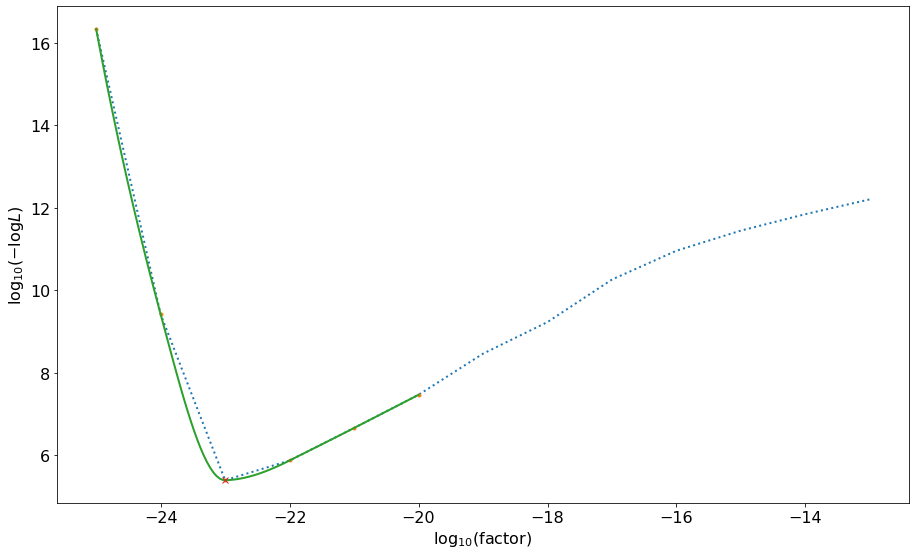

In [8]:
# Determine which factors to tests.
factors = 10.**(np.arange(-25, -12, 1))  # TODO Maybe use np.logspace(-25, -12, 14) or similar?

# Noise estimate to weigh the pixels.
# Poisson noise + background noise.
sig = np.sqrt(data + bkgd_noise**2)

# Tests all these factors.
tests = extract.get_tikho_tests(factors=factors, data=data, sig=sig)  # TODO sig is the uncertainty on the date here so it might be good to call it that?

# Find the best factor.
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

Testing factors...
20/20


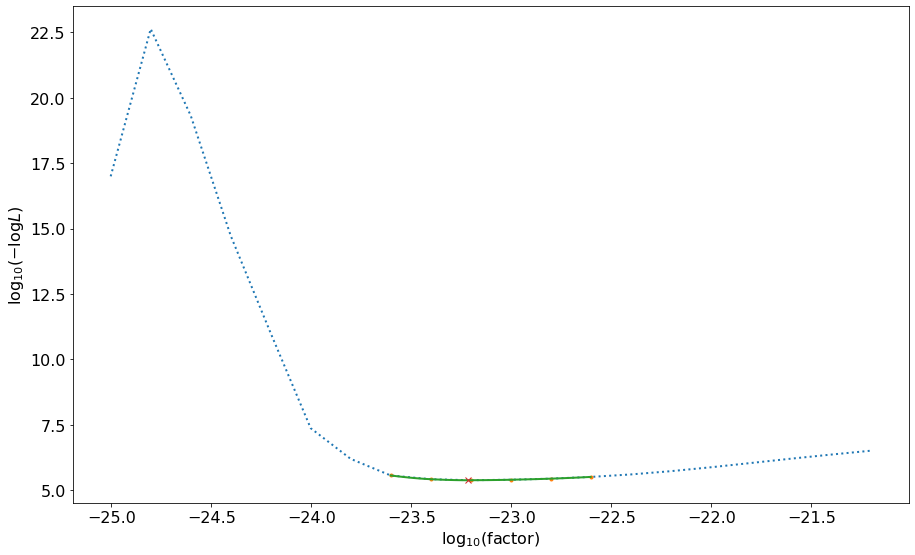

In [10]:
# Refine the grid (span 4 orders of magnitude).
best_fac = np.log10(best_fac)
factors = 10.**(np.arange(best_fac-2, best_fac+2, 0.2))  # TODO again maybe logspace would be better.

# No need to specify `data` and `sig` again. TODO: why not? Wouldn't it be better to require that to avoid confusion?
tests = extract.get_tikho_tests(factors, data=data, sig=sig)  # TODO is factors a mandatory keyword? It wasn´t passed that way in the cell above.
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

### Extract the oversampled spectrum $f_k$
TODO explain what f_k is.

Can be done in a loop for a timeseries and/or iteratively for different estimates of the reference files.

In [11]:
# Extract the spectrum.
f_k = extract.extract(data=data, sig=sig, tikhonov=True, factor=best_fac)  # Could we make change this method to __call__?

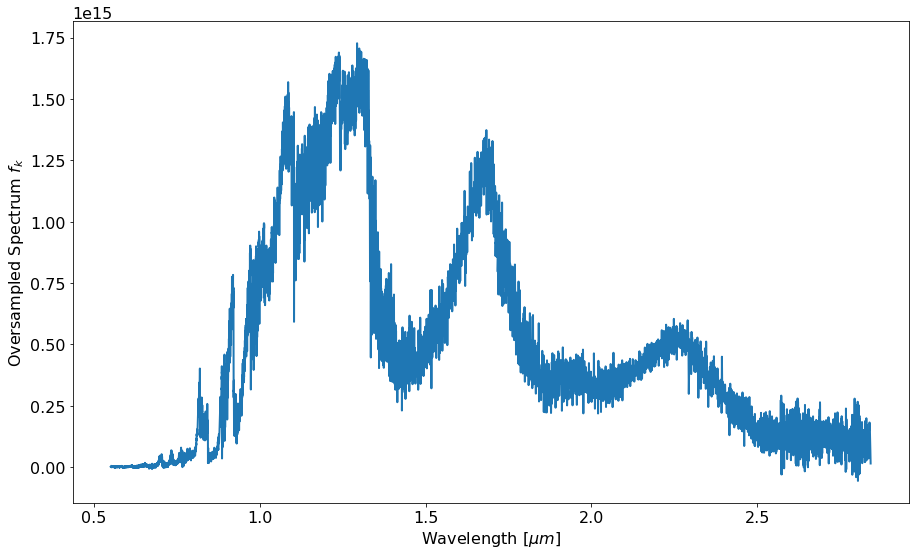

In [13]:
# Plot the extracted spectrum.
plt.plot(extract.lam_grid, f_k)

plt.xlabel("Wavelength [$\mu m$]")
plt.ylabel("Oversampled Spectrum $f_k$")  # TODO what are the units of the spectrum?

plt.tight_layout()
plt.show()

### Bin to pixel native sampling
To get a result comparable to typical extraction methods, we need to integrate the oversampled spectrum ($f_k$) to a grid representative of the native pixel sampling (for each order). This integration is done according to the equation
\begin{equation}
\rm{bin}_{i} = \int_{\lambda_{ni}^-}^{\lambda_{ni}^+} T_n(\lambda)\tilde{f}_n(\lambda)\lambda d\lambda \, ,
\end{equation}
where $n$ is a given order, $T_n$ is the throughput of the order. TODO What is $\tilde{f}_n$, it hasn't been defines yet? The result of this integral will be in fake (TODO why fake?) counts. 

One could directly extract the integrates flux by setting the throughput to $T_n(\lambda) = 1$, so in code: `def throughput(x): return np.ones_like(x)` TODO I'm not clear what is meant here? And where do I set the throuhgput to 1?

In [14]:
# Save the output in a list for different orders.

f_bin_list = []  # Integrated flux.
lam_bin_list = []  # Wavelength grid.

for i_ord in range(extract.n_ord): # TODO I think we can make it so we just get the order m=1,2 and never have to deal with an index as well.
    
    # Integrate.
    lam_bin, f_bin = extract.bin_to_pixel(f_k=f_k, i_ord=i_ord)
    
    # Save.
    f_bin_list.append(f_bin)
    lam_bin_list.append(lam_bin)

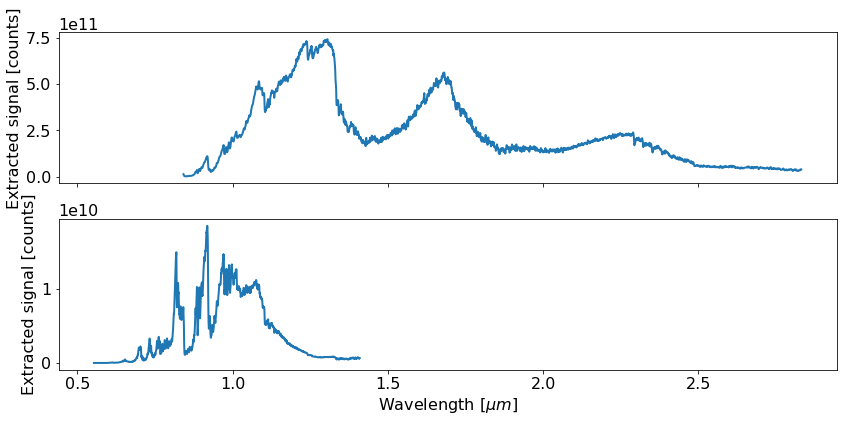

In [15]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6))

for i_ord in range(extract.n_ord):
    label = extract.orders[i_ord]
    ax[i_ord].plot(lam_bin_list[i_ord], f_bin_list[i_ord], label=label)
    
ax[0].set_ylabel("Extracted signal [counts]")
    
ax[1].set_xlabel("Wavelength [$\mu m$]")
ax[1].set_ylabel("Extracted signal [counts]")

plt.tight_layout()
plt.show()

## Quality estimate

### Rebuild the detector

In [16]:
rebuilt = extract.rebuild(f_k)

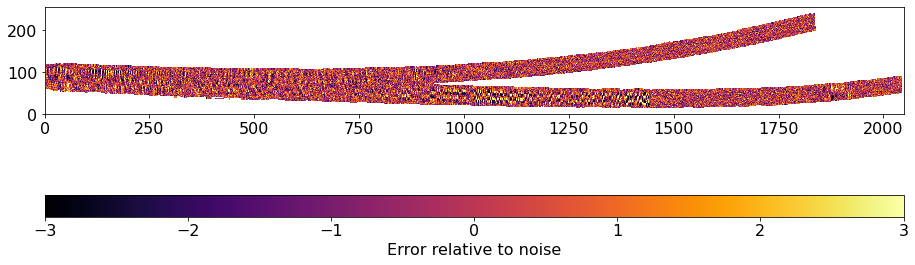

In [19]:
plt.subplot(111, aspect='equal')

plt.pcolormesh((rebuilt - data)/sig, vmin=-3, vmax=3)

plt.colorbar(label="Error relative to noise", orientation='horizontal', aspect=40)

plt.tight_layout()
plt.show()

We can see that we are very close to the photon noise limit in this case. There are some small structures in the 2nd order in the overlap region, but the extracted spectrum is dominated by the 1st order in this wavelength region anyway, due to the higher throughput.